In [70]:
# Main libraries that we will use in this kernel
import datetime
import numpy as np
import pandas as pd

# # garbage collector: free some memory is needed
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import calmap

# statistical package and some useful functions to analyze our timeseries
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as stattools

import time

from xgboost import XGBRegressor
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

def print_files():
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 150)

In [4]:
df = pd.read_csv("fourcasting.csv")

In [5]:
df.head()

,Alumno,Fecha,Canal,Comercial,Tipo de Pago,1 Pago,Precio,Edición
0,Lilieth,19/12/2018,Referral,Otros,Contado,5000,5000,DTM0419
1,Enrique Contreras,19/12/2018,Direct,Otros,Contado,5175,5175,DPM0419
2,Gerard Costa,01/02/2019,Direct,Otros,Plazos,536,3500,DPM0419
3,Alberto Mozo,08/02/2019,Paid Media,Otros,Plazos,350,3500,DPM0919
4,Carla Garcia,21/02/2019,Redes Sociales,Otros,Contado,4000,4000,DPM0419


In [6]:
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')

In [15]:
x = df[["Fecha", "Precio"]].set_index("Fecha").resample("M").sum()
y = df[["Fecha", "1 Pago"]].set_index("Fecha").resample("M").sum()


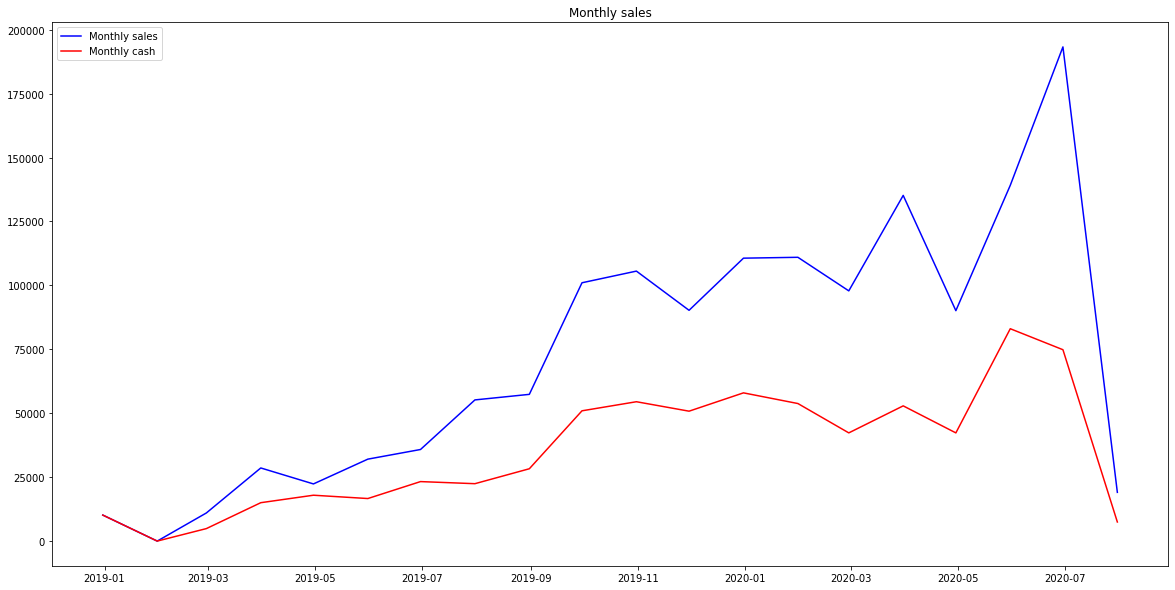

In [18]:
plt.figure(figsize = (20, 10))
plt.plot(x, color = "blue", label = "Monthly sales")
plt.plot(y, color = "red", label = "Monthly cash")
plt.title("Monthly sales")
plt.legend();

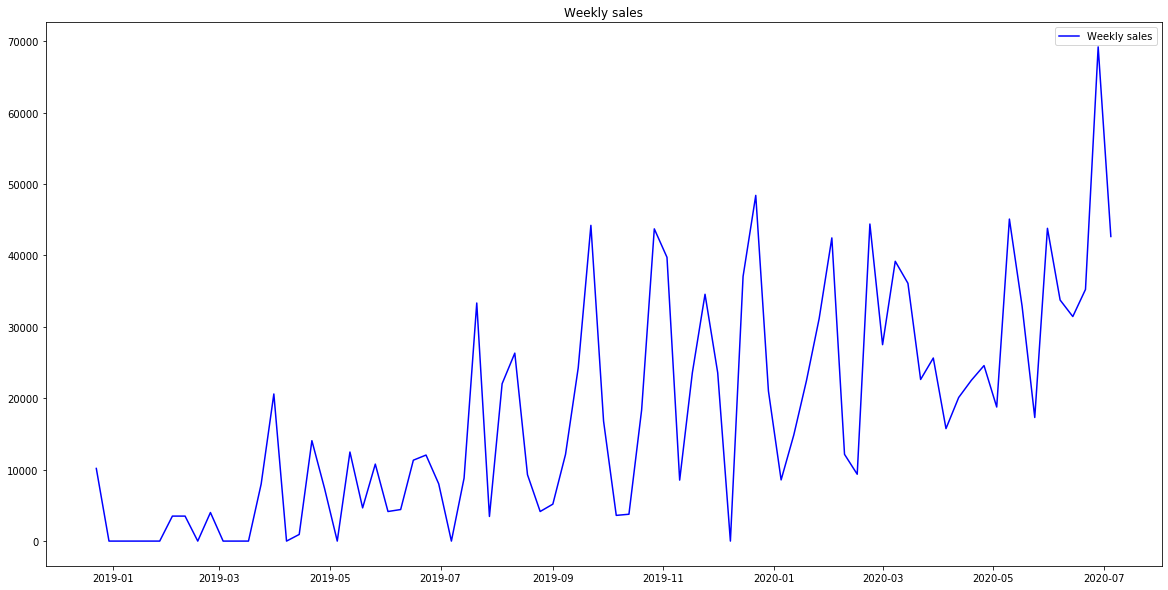

In [21]:
# perform the same operations but on a weekly basis
x = df[["Fecha", "Precio"]].set_index("Fecha").resample("W").sum()

plt.figure(figsize = (20, 10))
plt.plot(x.index, x, color = "blue", label = "Weekly sales")
plt.title("Weekly sales")
plt.legend();

In [22]:
# we can observe a general trend of decrasing sales.
# let's add a second axis to see the variation of intradays sales

# select the columns of interest
df_var = df[["Fecha", "Precio"]]

# convert to datetime
df_var["Fecha"] = pd.to_datetime(df["Fecha"], format = '%d/%m/%Y')

# set date as index
df_var.set_index("Fecha", inplace = True)

# resample/groupby by date and convert to frame the total daily sales
df_var = df_var.resample("W")["Precio"].sum().to_frame()

# calculate the intra week variation between total sales
df_var["Variation"] = df_var["Precio"].diff()/df_var["Precio"].shift(1)

df_var.head()

,Precio,Variation
Fecha,,
2018-12-23,10175,NaN
2018-12-30,0,-1.0
2019-01-06,0,NaN
2019-01-13,0,NaN
2019-01-20,0,NaN


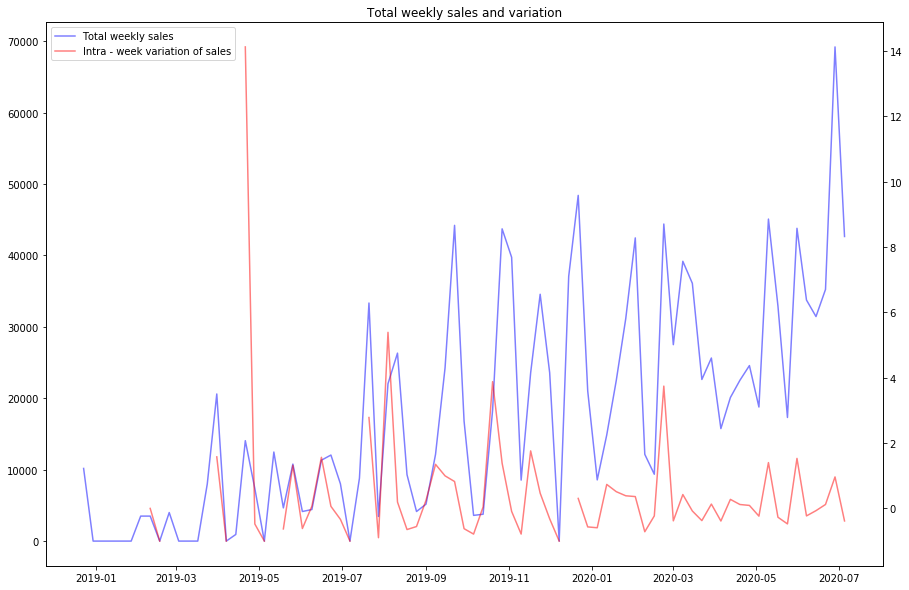

In [23]:
# separate x and y
y_sales = df_var["Precio"]
y_variation = df_var["Variation"]

# instanciate the figure
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

# plot the total sales
plot1 = ax.plot(y_sales, label = "Total weekly sales", color = "blue", alpha = 0.5)

# create a secondary axis and plot the variation data
ax_bis = ax.twinx()
plot2 = ax_bis.plot(y_variation, label = "Intra - week variation of sales", color = "red", alpha = 0.5)

# create a common legend for both plots
lns = plot1 + plot2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc = "upper left")

# add a custom title to the plot
ax.set_title("Total weekly sales and variation");

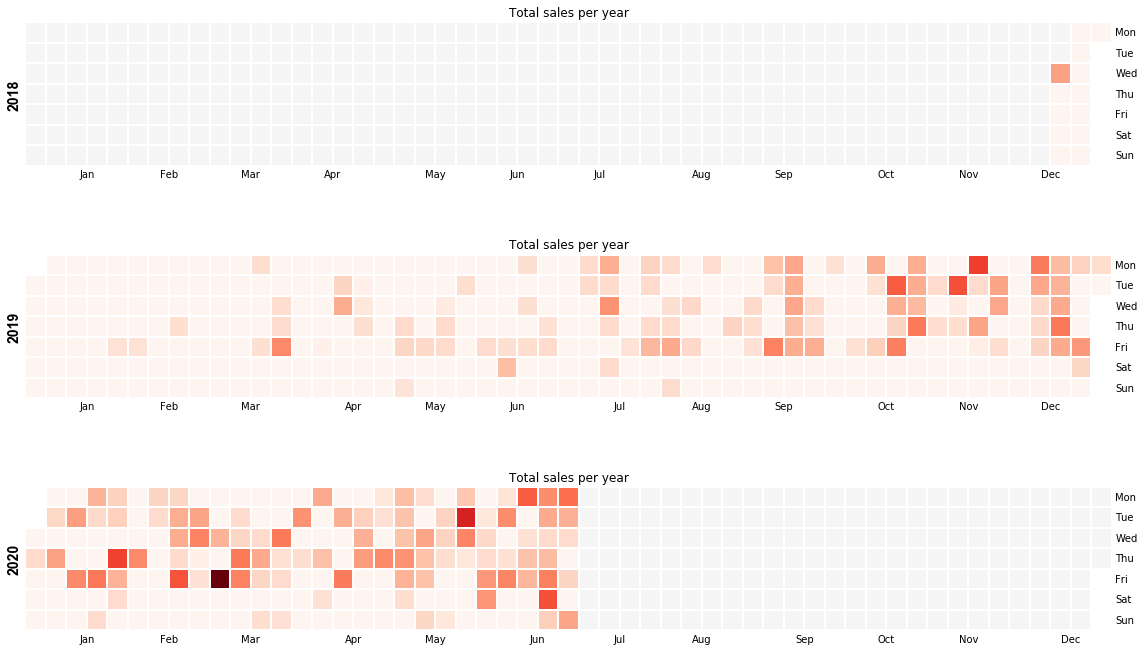

In [28]:
# calendar heatmaps are really useful to see the overall activity for a certain period of time per day and per month.
# let's build one using python.
# we will be using the calmap package for this, because it makes it extremenly easy to plot this data
# select the columns
df_calendar = df[["Fecha", "Precio"]]

# set date as index and resample
df_calendar.set_index("Fecha", inplace = True)
# notice that this time, we don't convert it to_frame()
# df_calendar is a pandas series
# THIS IS IMPORTANT since calmap expects a series
# with a datetime index and the values to plot
df_calendar = df_calendar.resample("D")["Precio"].sum()

# ----------------------------------------------------------------------------------------------------
# plot the data using calmap
calmap.calendarplot(df_calendar, # pass the series
                    fig_kws = {'figsize': (16,10)}, 
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'}
                   );

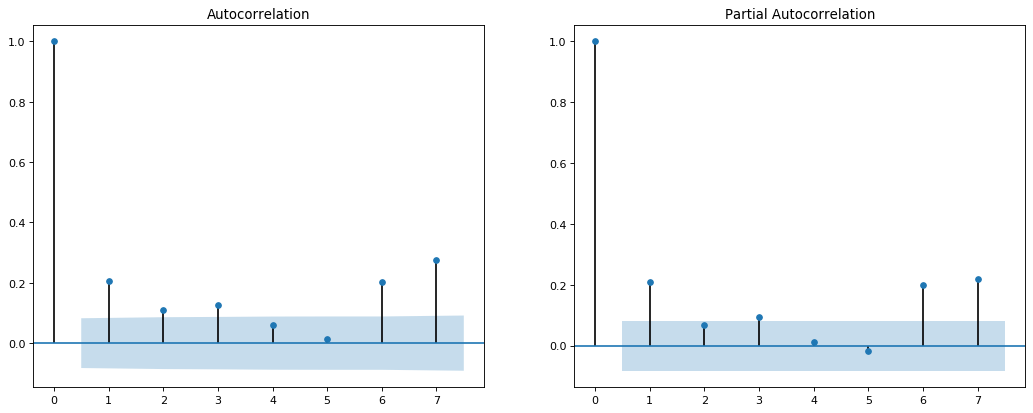

In [29]:
# Basically here we compare the a series again itself but with some lags.
# These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

# More info: 
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,6), dpi = 80)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module

# The AutoCorrelation plot: compares a value v with the value v but n times in the past.
plot_acf(df.set_index("Fecha").resample("D")["Precio"].sum(), ax = ax1, lags = 7)

# The Parcial AutoCorrelation plot: partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.
plot_pacf(df.set_index("Fecha").resample("D")["Precio"].sum(), ax = ax2, lags = 7);

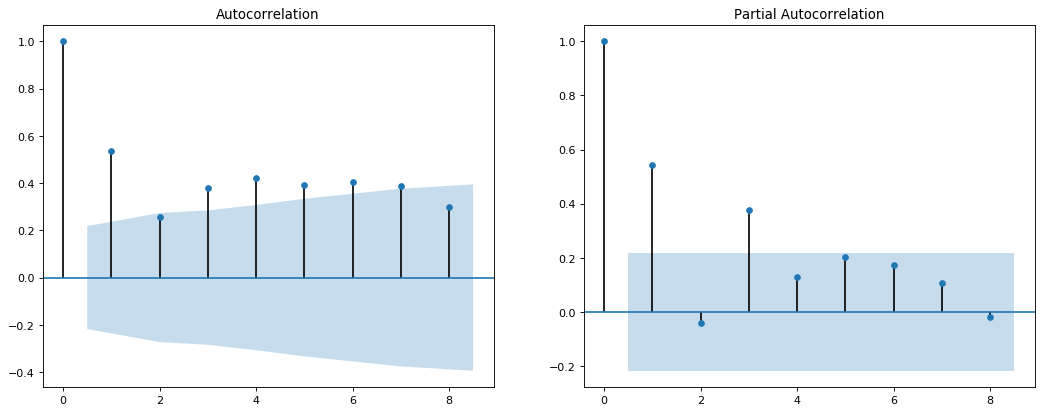

In [31]:
# Basically here we compare the a series again itself but with some lags.
# These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

# More info: 
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,6), dpi = 80)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module

# The AutoCorrelation plot: compares a value v with the value v but n times in the past.
plot_acf(df.set_index("Fecha").resample("W")["Precio"].sum(), ax = ax1, lags = 8)

# The Parcial AutoCorrelation plot: partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.
plot_pacf(df.set_index("Fecha").resample("W")["Precio"].sum(), ax = ax2, lags = 8);

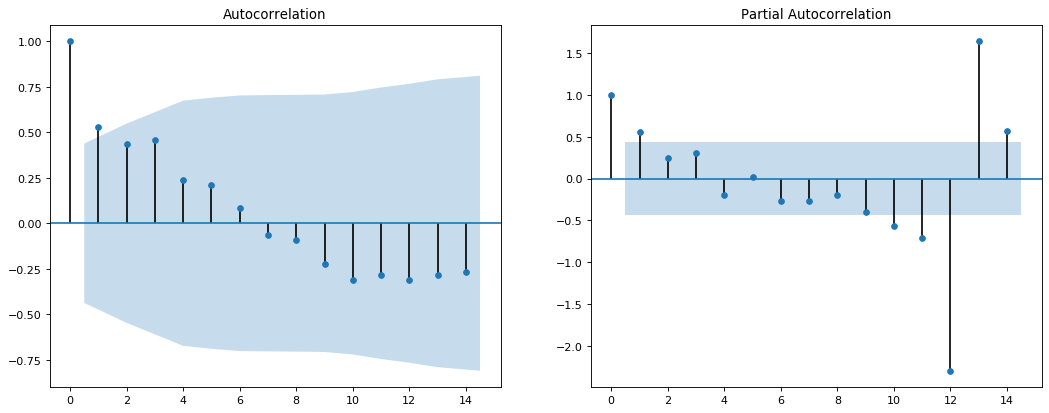

In [32]:
# Basically here we compare the a series again itself but with some lags.
# These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

# More info: 
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,6), dpi = 80)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module

# The AutoCorrelation plot: compares a value v with the value v but n times in the past.
plot_acf(df.set_index("Fecha").resample("M")["Precio"].sum(), ax = ax1, lags = 14)

# The Parcial AutoCorrelation plot: partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.
plot_pacf(df.set_index("Fecha").resample("M")["Precio"].sum(), ax = ax2, lags = 14);

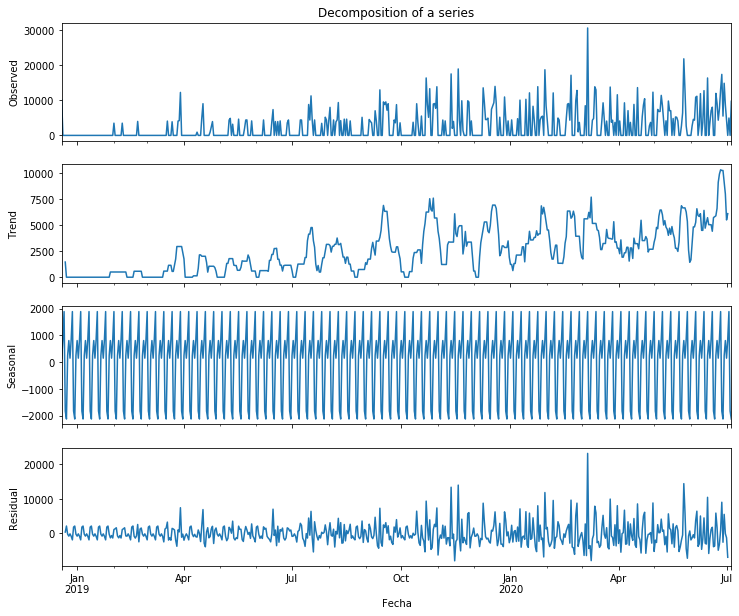

In [33]:
# Useful for:
# The theory behind timeseries, says that a series can be decomposed into 3 parts
# The trend
# The seasonal part
# And the residual
# This plots shows how to do this

# More info: 
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

df_timeindex = df.set_index("Fecha").resample("D")["Precio"].sum().to_frame()

# decompose the series using stats module
# results in this case is a special class 
# whose attributes we can acess
result = seasonal_decompose(df_timeindex["Precio"])

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
# make the subplots share teh x axis
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize = (12,10))

# ----------------------------------------------------------------------------------------------------
# plot the data
# using this cool thread:
# https://stackoverflow.com/questions/45184055/how-to-plot-multiple-seasonal-decompose-plots-in-one-figure
# This allows us to have more control over the plots

# plot the original data
result.observed.plot(ax = axes[0], legend = False)
axes[0].set_ylabel('Observed')
axes[0].set_title("Decomposition of a series")

# plot the trend
result.trend.plot(ax = axes[1], legend = False)
axes[1].set_ylabel('Trend')

# plot the seasonal part
result.seasonal.plot(ax = axes[2], legend = False)
axes[2].set_ylabel('Seasonal')

# plot the residual
result.resid.plot(ax = axes[3], legend = False)
axes[3].set_ylabel('Residual')

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# get the xticks and the xticks labels
xtick_location = df_timeindex.index.tolist()

# set the xticks to be every 6'th entry
# every 6 months
ax.set_xticks(xtick_location);

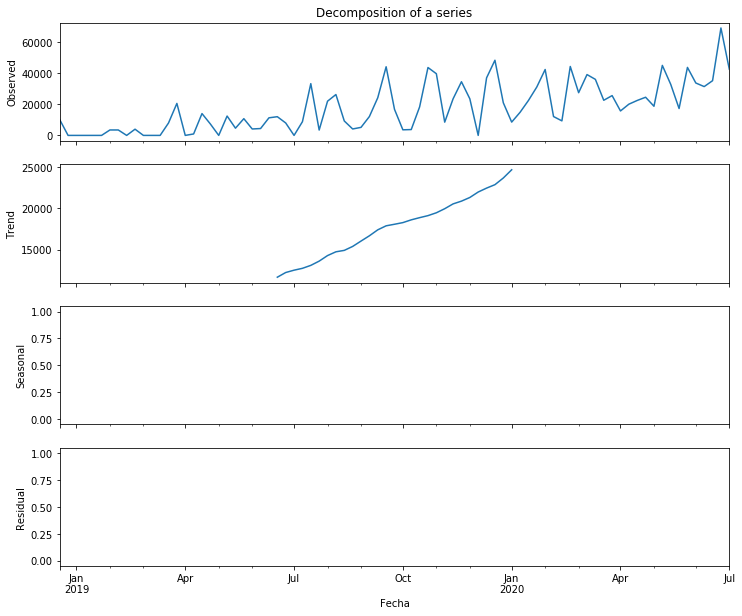

In [34]:
# Useful for:
# The theory behind timeseries, says that a series can be decomposed into 3 parts
# The trend
# The seasonal part
# And the residual
# This plots shows how to do this

# More info: 
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

df_timeindex = df.set_index("Fecha").resample("W")["Precio"].sum().to_frame()

# decompose the series using stats module
# results in this case is a special class 
# whose attributes we can acess
result = seasonal_decompose(df_timeindex["Precio"])

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
# make the subplots share teh x axis
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize = (12,10))

# ----------------------------------------------------------------------------------------------------
# plot the data
# using this cool thread:
# https://stackoverflow.com/questions/45184055/how-to-plot-multiple-seasonal-decompose-plots-in-one-figure
# This allows us to have more control over the plots

# plot the original data
result.observed.plot(ax = axes[0], legend = False)
axes[0].set_ylabel('Observed')
axes[0].set_title("Decomposition of a series")

# plot the trend
result.trend.plot(ax = axes[1], legend = False)
axes[1].set_ylabel('Trend')

# plot the seasonal part
result.seasonal.plot(ax = axes[2], legend = False)
axes[2].set_ylabel('Seasonal')

# plot the residual
result.resid.plot(ax = axes[3], legend = False)
axes[3].set_ylabel('Residual')

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# get the xticks and the xticks labels
xtick_location = df_timeindex.index.tolist()

# set the xticks to be every 6'th entry
# every 6 months
ax.set_xticks(xtick_location);

In [35]:
df

,Alumno,Fecha,Canal,Comercial,Tipo de Pago,1 Pago,Precio,Edición
0,Lilieth,2018-12-19,Referral,Otros,Contado,5000,5000,DTM0419
1,Enrique Contreras,2018-12-19,Direct,Otros,Contado,5175,5175,DPM0419
2,Gerard Costa,2019-02-01,Direct,Otros,Plazos,536,3500,DPM0419
3,Alberto Mozo,2019-02-08,Paid Media,Otros,Plazos,350,3500,DPM0919
4,Carla Garcia,2019-02-21,Redes Sociales,Otros,Contado,4000,4000,DPM0419
...,...,...,...,...,...,...,...,...
355,Oriol Rubio,2020-06-30,Paid Search,Sergio del Frago,Contado Plazos,300,4347,DTM0920
356,Andrea Fernandez,2020-07-01,Direct,Sergio del Frago,Contado Plazos,1000,4347,DTM0920
357,Luis Enrique Sánchez Betancourt,2020-07-03,Paid Search,Jorge Jimenez,Contado,4968,4968,DSC0920
358,Raúl Sastre,2020-07-05,Paid Search,Sergio del Frago,Contado Plazos,1000,4779,DSC0920STR


In [39]:
df['Comercial'].value_counts()

Joel Orteu          85
Jorge Jimenez       79
Irene Safer         62
Sergio del Frago    33
Albert Cobacho      29
Veronica Cignoli    22
Ahmad Halloun       21
Jordi Tena          16
Otros                9
Gisela Moreno        3
Joanne Mattar        1
Name: Comercial, dtype: int64

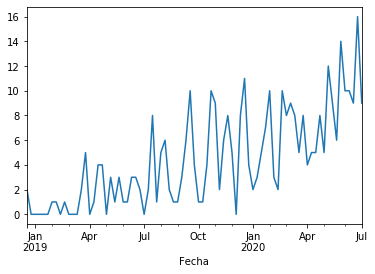

In [45]:
df.set_index("Fecha").resample("W")["Comercial"].count().plot()

In [60]:
df['year'] = df['Fecha'].dt.year
df['month'] = df['Fecha'].dt.month
df['weekday'] = df['Fecha'].dt.weekday
df['week'] = df['Fecha'].dt.week


In [63]:
df.pivot_table(index=['year','month'], values=['1 Pago','Precio'], aggfunc=[len, sum, np.mean])

len           sum                 mean             
             1 Pago Precio 1 Pago  Precio       1 Pago       Precio
year   month                                                       
2018.0 12.0       2      2  10175   10175  5087.500000  5087.500000
2019.0 2.0        3      3   4886   11000  1628.666667  3666.666667
       3.0        7      7  15015   28600  2145.000000  4085.714286
       4.0        9      9  17939   22356  1993.222222  2484.000000
       5.0        8      8  16641   32049  2080.125000  4006.125000
       6.0        9      9  23268   35820  2585.333333  3980.000000
       7.0       13     13  22449   55211  1726.846154  4247.000000
       8.0       13     13  28289   57384  2176.076923  4414.153846
       9.0       24     24  50952  101026  2123.000000  4209.416667
       10.0      24     24  54502  105587  2270.916667  4399.458333
       11.0      21     21  50806   90255  2419.333333  4297.857143
       12.0      24     24  57970  110648  2415.416667  4610.333333
2020.0 1.0       25     25  53797  110987  2151.880000  4439.480000
       2.0       24     24  42318   97856  1763.250000  4077.333333
       3.0       33     33  52885  135191  1602.575758  4096.696970
       4.0       24     24  42314   90117  1763.083333  3754.875000
       5.0       41     41  83053  139139  2025.682927  3393.634146
       6.0       50     50  74843  193265  1496.860000  3865.300000
       7.0        4      4   7468   19062  1867.000000  4765.500000

In [68]:
df.pivot_table(index=['year','month','Comercial'], values=['1 Pago','Precio'], aggfunc=[len, sum, np.mean])

len           sum                mean  \
                              1 Pago Precio 1 Pago Precio       1 Pago   
year   month Comercial                                                   
2018.0 12.0  Otros                 2      2  10175  10175  5087.500000   
2019.0 2.0   Otros                 3      3   4886  11000  1628.666667   
       3.0   Albert Cobacho        6      6  10790  24375  1798.333333   
             Otros                 1      1   4225   4225  4225.000000   
       4.0   Albert Cobacho        5      5  11507  11972  2301.400000   
             Jorge Jimenez         4      4   6432  10384  1608.000000   
       5.0   Albert Cobacho        4      4  10541  18067  2635.250000   
             Jorge Jimenez         4      4   6100  13982  1525.000000   
       6.0   Albert Cobacho        2      2   1200   8372   600.000000   
             Joel Orteu            3      3  12048  12050  4016.000000   
             Jorge Jimenez         4      4  10020  15398  2505.000000   
       7.0   Albert Cobacho        4      4   9849  17229  2462.250000   
             Joel Orteu            3      3   5050  12247  1683.333333   
             Jorge Jimenez         6      6   7550  25735  1258.333333   
       8.0   Ahmad Halloun         1      1   4420   4420  4420.000000   
             Albert Cobacho        5      5  11340  21833  2268.000000   
             Irene Safer           1      1   4709   5175  4709.000000   
             Joel Orteu            4      4   5820  17587  1455.000000   
             Jorge Jimenez         2      2   2000   8369  1000.000000   
       9.0   Ahmad Halloun         3      3   6709  14351  2236.333333   
             Albert Cobacho        2      2   4822   8598  2411.000000   
             Irene Safer           9      9  25702  39534  2855.777778   
             Joel Orteu            4      4   3500  16649   875.000000   
             Jorge Jimenez         6      6  10219  21894  1703.166667   
       10.0  Ahmad Halloun         3      3   3000  15099  1000.000000   
             Irene Safer           7      7  20438  29974  2919.714286   
             Joel Orteu           10     10  27064  42660  2706.400000   
             Jorge Jimenez         4      4   4000  17854  1000.000000   
       11.0  Ahmad Halloun         3      3   6879  14812  2293.000000   
             Irene Safer           5      5   5880  19878  1176.000000   
             Joel Orteu            9      9  27407  38150  3045.222222   
             Jorge Jimenez         4      4  10640  17415  2660.000000   
       12.0  Ahmad Halloun         2      2   4898   9208  2449.000000   
             Gisela Moreno         1      1   1000   6555  1000.000000   
             Irene Safer           4      4  11916  18164  2979.000000   
             Joel Orteu            8      8  18309  35217  2288.625000   
             Jorge Jimenez         7      7  19847  32246  2835.285714   
             Veronica Cignoli      2      2   2000   9258  1000.000000   
2020.0 1.0   Irene Safer           4      4  12050  20107  3012.500000   
             Joel Orteu           10     10  16717  42678  1671.700000   
             Jordi Tena            2      2   5428   8748  2714.000000   
             Jorge Jimenez         7      7  17602  30229  2514.571429   
             Veronica Cignoli      2      2   2000   9225  1000.000000   
       2.0   Ahmad Halloun         2      2   1500   1500   750.000000   
             Gisela Moreno         2      2   2000   8856  1000.000000   
             Irene Safer           3      3   5550  13986  1850.000000   
             Joel Orteu            5      5   7095  21372  1419.000000   
             Jordi Tena            2      2   2000   8145  1000.000000   
             Jorge Jimenez         6      6  15085  27351  2514.166667   
             Veronica Cignoli      4      4   9088  16646  2272.000000   
       3.0   Irene Safer           8      8  15861  31073  1982.625000   
             Joel Orteu            8 

In [71]:
df.pivot_table(index=['year','month','Canal'], values=['1 Pago','Precio'], aggfunc=[len, sum, np.mean])

len           sum                mean  \
                            1 Pago Precio 1 Pago Precio       1 Pago   
year   month Canal                                                     
2018.0 12.0  Direct              1      1   5175   5175  5175.000000   
             Referral            1      1   5000   5000  5000.000000   
2019.0 2.0   Direct              1      1    536   3500   536.000000   
             Paid Media          1      1    350   3500   350.000000   
             Redes Sociales      1      1   4000   4000  4000.000000   
       3.0   Direct              1      1   4095   4095  4095.000000   
             Organic             3      3   5395  12285  1798.333333   
             Redes Sociales      3      3   5525  12220  1841.666667   
       4.0   Paid Media          3      3   8134  12086  2711.333333   
             Referral            6      6   9805  10270  1634.166667   
       5.0   Direct              1      1   1000   1969  1000.000000   
             Organic             2      2   4100   7625  2050.000000   
             Paid Media          3      3   9542  12930  3180.666667   
             Redes Sociales      2      2   1999   9525   999.500000   
       6.0   Direct              2      2   8096   8097  4048.000000   
             Organic             2      2   1200   8372   600.000000   
             Paid Media          2      2   5420   8109  2710.000000   
             Redes Sociales      1      1   3600   3600  3600.000000   
             Referral            2      2   4952   7642  2476.000000   
       7.0   Direct              3      3   7900  11299  2633.333333   
             Organic             1      1   1000   4399  1000.000000   
             Paid Media          9      9  13549  39513  1505.444444   
       8.0   Direct              4      4  11129  18240  2782.250000   
             Organic             2      2   8840   8840  4420.000000   
             Paid Media          4      4   6420  16814  1605.000000   
             Paid Search         3      3   1900  13490   633.333333   
       9.0   Direct              7      7  14618  28296  2088.285714   
             Organic             1      1   3100   3600  3100.000000   
             Paid Media          9      9  16304  37945  1811.555556   
             Paid Search         6      6  13108  26985  2184.666667   
             Referral            1      1   3822   4200  3822.000000   
       10.0  Direct              6      6  18914  25505  3152.333333   
             Organic             1      1   1000   4657  1000.000000   
             Paid Media         13     13  23264  57558  1789.538462   
             Paid Search         1      1   1000   4399  1000.000000   
             Redes Sociales      2      2   5569   8713  2784.500000   
             Referral            1      1   4755   4755  4755.000000   
       11.0  Direct              6      6  16925  25617  2820.833333   
             Organic             2      2   5879   8479  2939.500000   
             Paid Media         10     10  20372  42124  2037.200000   
             Paid Search         2      2   6630   9773  3315.000000   
             Referral            1      1   1000   4262  1000.000000   
       12.0  Direct              1      1   1000   3867  1000.000000   
             Organic             1      1   1000   4513  1000.000000   
             Paid Media         21     21  51257  97555  2440.809524   
             Paid Search         1      1   4713   4713  4713.000000   
2020.0 1.0   Direct              5      5  16368  24685  3273.600000   
             Organic             8      8  11050  36754  1381.250000   
             Paid Media          8      8  22879  33256  2859.875000   
             Paid Search         3      3   2500  12044   833.333333   
             Redes Sociales      1      1   1000   4248  1000.000000   
       2.0   Direct              6      6   7888  28050  1314.666667   
             Organic             3      3   5795  12975  1931.666667   

In [72]:
df.pivot_table(index=['Canal'], values=['1 Pago','Precio'], aggfunc=[len, sum, np.mean])

len            sum                 mean             
               1 Pago Precio  1 Pago  Precio       1 Pago       Precio
Canal                                                                 
Direct             69     69  150885  291278  2186.739130  4221.420290
Organic            45     45   74097  181451  1646.600000  4032.244444
Paid Media        174    174  340259  682545  1955.511494  3922.672414
Paid Search        46     46   82569  199221  1794.978261  4330.891304
Redes Sociales     12     12   29226   49839  2435.500000  4153.250000
Referral           14     14   32534   41394  2323.857143  2956.714286

In [73]:
df.pivot_table(index=['Comercial'], values=['1 Pago','Precio'], aggfunc=[len, sum, np.mean])

len            sum                 mean             
                 1 Pago Precio  1 Pago  Precio       1 Pago       Precio
Comercial                                                               
Ahmad Halloun        21     21   34073   81337  1622.523810  3873.190476
Albert Cobacho       29     29   60049  110446  2070.655172  3808.482759
Gisela Moreno         3      3    3000   15411  1000.000000  5137.000000
Irene Safer          62     62  137009  254655  2209.822581  4107.338710
Joanne Mattar         1      1     500    4130   500.000000  4130.000000
Joel Orteu           85     85  164042  356391  1929.905882  4192.835294
Jordi Tena           16     16   24572   65361  1535.750000  4085.062500
Jorge Jimenez        79     79  151647  317892  1919.582278  4023.949367
Otros                 9      9   19286   25400  2142.888889  2822.222222
Sergio del Frago     33     33   85311  124908  2585.181818  3785.090909
Veronica Cignoli     22     22   30081   89797  1367.318182  4081.681818

In [74]:
df.pivot_table(index=['Edición'], values=['1 Pago','Precio'], aggfunc=[len, sum, np.mean])

len           sum                mean             
             1 Pago Precio 1 Pago Precio       1 Pago       Precio
Edición                                                           
AA0919           19     19  47149  84918  2481.526316  4469.368421
B2B0920           2      2   4017   7847  2008.500000  3923.500000
B2B0920STR        1      1    500   2700   500.000000  2700.000000
DBE062020         1      1    500   4810   500.000000  4810.000000
DM0520-EN        15     15  17515  48245  1167.666667  3216.333333
DMEN0920          6      6   4800  24367   800.000000  4061.166667
DPM0220          19     19  40203  85445  2115.947368  4497.105263
DPM0320-ON       20     20  28797  88598  1439.850000  4429.900000
DPM0419           9      9  15756  29055  1750.666667  3228.333333
DPM0520          12     12  17542  53109  1461.833333  4425.750000
DPM0520STR        5      5  11091  15658  2218.200000  3131.600000
DPM0919          23     23  53307  97801  2317.695652  4252.217391
DPM0920          11     11  15135  32206  1375.909091  2927.818182
DPM0920STR        1      1    500   3717   500.000000  3717.000000
DPMEN0920-ON      9      9  15340  40572  1704.444444  4508.000000
DSC0520          17     17  34763  78635  2044.882353  4625.588235
DSC0520STR        3      3   4250   8400  1416.666667  2800.000000
DSC0920          13     13  20662  61637  1589.384615  4741.307692
DSC0920STR        9      9  14810  27906  1645.555556  3100.666667
DTM0120          13     13  28657  55304  2204.384615  4254.153846
DTM0419           8      8  18987  19452  2373.375000  2431.500000
DTM0520          12     12  35598  51239  2966.500000  4269.916667
DTM0520STR        9      9  18900  24030  2100.000000  2670.000000
DTM0920           4      4   2800  17136   700.000000  4284.000000
DTM0920ST         4      4   5265  12330  1316.250000  3082.500000
DTM1019          15     15  24177  61286  1611.800000  4085.733333
FSD0320          12     12  24644  56181  2053.666667  4681.750000
FSD0520-EN        1      1   1000   4398  1000.000000  4398.000000
FSD0620          10     10  29229  46630  2922.900000  4663.000000
FSD0620STR        4      4   7260  11160  1815.000000  2790.000000
FSD0919          16     16  44719  69862  2794.937500  4366.375000
FSD0920          11     11  19518  50778  1774.363636  4616.181818
SOB0220          13     13  23195  49195  1784.230769  3784.230769
SOB1019          12     12  26119  43367  2176.583333  3613.916667
UXUI0620         13     13  39773  53737  3059.461538  4133.615385
UXUI0620STR       8      8  13092  24017  1636.500000  3002.125000

In [75]:
df.pivot_table(index=['year','month','Edición'], values=['1 Pago','Precio'], aggfunc=[len, sum, np.mean])

len           sum                mean  \
                          1 Pago Precio 1 Pago Precio       1 Pago   
year   month Edición                                                 
2018.0 12.0  DPM0419           1      1   5175   5175  5175.000000   
             DTM0419           1      1   5000   5000  5000.000000   
2019.0 2.0   DPM0419           2      2   4536   7500  2268.000000   
             DPM0919           1      1    350   3500   350.000000   
       3.0   DPM0220           1      1    650   3900   650.000000   
             DPM0419           4      4   6045  16380  1511.250000   
             DPM0919           2      2   8320   8320  4160.000000   
       4.0   DTM0419           7      7  13987  14452  1998.142857   
             DTM1019           2      2   3952   7904  1976.000000   
       5.0   DPM0220           1      1    900   4425   900.000000   
             DPM0919           4      4   7143  15375  1785.750000   
             DTM1019           1      1    999   4650   999.000000   
             FSD0919           1      1   4399   4399  4399.000000   
             SOB1019           1      1   3200   3200  3200.000000   
       6.0   DPM0919           3      3   8764  12984  2921.333333   
             DTM1019           5      5  10904  19236  2180.800000   
             SOB1019           1      1   3600   3600  3600.000000   
       7.0   DPM0919           4      4   3100  17907   775.000000   
             DTM0520           1      1    600   4399   600.000000   
             DTM1019           1      1   1000   4960  1000.000000   
             FSD0919           7      7  17749  27945  2535.571429   
       8.0   DPM0220           1      1   1000   4144  1000.000000   
             DPM0919           8      8  21080  35165  2635.000000   
             DTM1019           2      2   1000   9300   500.000000   
             FSD0919           1      1   4709   5175  4709.000000   
             SOB1019           1      1    500   3600   500.000000   
       9.0   DPM0220           2      2   1500   9273   750.000000   
             DPM0320-ON        1      1   1000   5576  1000.000000   
             DPM0919           1      1   4550   4550  4550.000000   
             DPM0920           1      1   4399   4399  4399.000000   
             DTM1019           4      4   6322  15236  1580.500000   
             FSD0320           1      1   1000   4399  1000.000000   
             FSD0919           7      7  17862  32343  2551.714286   
             SOB1019           7      7  14319  25250  2045.571429   
       10.0  AA0919            5      5   7261  19420  1452.200000   
             DPM0220           5      5  15764  22993  3152.800000   
             DPM0320-ON        2      2   2000  10701  1000.000000   
             DTM0120           2      2   5569   8713  2784.500000   
             FSD0320           4      4   7399  17854  1849.750000   
             FSD0520-EN        1      1   1000   4398  1000.000000   
             FSD0620           2      2   9509   9509  4754.500000   
             FSD0920           1      1   1000   4399  1000.000000   
             SOB0220           2      2   5000   7600  2500.000000   
       11.0  AA0919            4      4  10056  16831  2514.000000   
             DPM0220           3      3   6523  14941  2174.333333   
             DPM0320-ON        2      2   5879  10414  2939.500000   
             DPM0520STR        1      1   4879   4879  4879.000000   
             DTM0120           4      4   8436  16865  2109.000000   
             FSD0320           2      2   2380   6072  1190.000000   
             FSD0620           1      1   5630   5630  5630.000000   
             FSD0920           1      1   5023   5023  5023.000000   
             SOB0220           3      3   2000   9600   666.666667   
       12.0  AA0919            8      8  27832  38578  3479.000000   
             DBE062020         1      1    500   4810   500.000000   
             DPM0220           2      2

In [76]:
df_pivot_edicion = df.pivot_table(index=['year','month','Edición'], values=['1 Pago','Precio'], aggfunc=[len, sum, np.mean])

In [77]:
df_pivot_edicion.columns

MultiIndex([( 'len', '1 Pago'),
            ( 'len', 'Precio'),
            ( 'sum', '1 Pago'),
            ( 'sum', 'Precio'),
            ('mean', '1 Pago'),
            ('mean', 'Precio')],
           )

In [80]:
df[df['Edición'].str.contains('DTM')].pivot_table(index=['year','month','Edición'], values=['1 Pago','Precio'], aggfunc=[len, sum, np.mean])


len           sum                mean             
                        1 Pago Precio 1 Pago Precio       1 Pago       Precio
year   month Edición                                                         
2018.0 12.0  DTM0419         1      1   5000   5000  5000.000000  5000.000000
2019.0 4.0   DTM0419         7      7  13987  14452  1998.142857  2064.571429
             DTM1019         2      2   3952   7904  1976.000000  3952.000000
       5.0   DTM1019         1      1    999   4650   999.000000  4650.000000
       6.0   DTM1019         5      5  10904  19236  2180.800000  3847.200000
       7.0   DTM0520         1      1    600   4399   600.000000  4399.000000
             DTM1019         1      1   1000   4960  1000.000000  4960.000000
       8.0   DTM1019         2      2   1000   9300   500.000000  4650.000000
       9.0   DTM1019         4      4   6322  15236  1580.500000  3809.000000
       10.0  DTM0120         2      2   5569   8713  2784.500000  4356.500000
       11.0  DTM0120         4      4   8436  16865  2109.000000  4216.250000
       12.0  DTM0120         6      6   9875  24949  1645.833333  4158.166667
2020.0 1.0   DTM0120         1      1   4777   4777  4777.000000  4777.000000
             DTM0520         3      3   9693  13490  3231.000000  4496.666667
       2.0   DTM0520         1      1   4140   4140  4140.000000  4140.000000
       3.0   DTM0520         6      6  17070  25115  2845.000000  4185.833333
             DTM0520STR      2      2   1000   5130   500.000000  2565.000000
             DTM0920ST       1      1    300   2700   300.000000  2700.000000
       4.0   DTM0520STR      2      2   4400   5400  2200.000000  2700.000000
       5.0   DTM0520         1      1   4095   4095  4095.000000  4095.000000
             DTM0520STR      5      5  13500  13500  2700.000000  2700.000000
       6.0   DTM0920         3      3   1800  12789   600.000000  4263.000000
             DTM0920ST       3      3   4965   9630  1655.000000  3210.000000
       7.0   DTM0920         1      1   1000   4347  1000.000000  4347.000000

In [85]:
x = df[["Fecha", "Edición"]].set_index("Fecha").resample("W").sum()

plt.figure(figsize = (20, 10))
plt.plot(x.index, x[x['Edición'].str.contains('DTM')], color = "blue", label = "Weekly sales")
plt.title("Weekly sales")
plt.legend();

ValueError: cannot index with vector containing NA / NaN values

<Figure size 1440x720 with 0 Axes>

In [87]:
x

,Edición
Fecha,
2018-12-23,DTM0419DPM0419
2018-12-30,0
2019-01-06,0
2019-01-13,0
2019-01-20,0
2019-01-27,0
2019-02-03,DPM0419
2019-02-10,DPM0919
2019-02-17,0
